# Model building and evaluation

This notebook is the (hopefully streamlined) version of the data_exploration notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
import os # work with system    
import cv2 # work with images
import numpy as np # arrays and numerical analysis  
import matplotlib.pyplot as plt # for data plots

import sklearn.linear_model # linear models
from sklearn.model_selection import train_test_split # data splitting
from sklearn import metrics # model evaluation
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import random # for random sampling 

### set working directory in data folder
os.chdir("drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject")

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvidia-smi

Wed Mar  1 19:57:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# estimated runtime: 45 seconds
counter = 0 # if desired to break loop

# labels and filenames should match since they are appended in order
filenames = []
labels = []

# one image does not open properly
empty_img = "MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF8/IMG_7087.JPG"
# walk through all directories and files in current working directory
for root, dir, files in os.walk(os.getcwd()):
    
    for jpg in files:
        if empty_img in os.path.join(root, jpg):
          print(empty_img)
          continue

        # if jpg file, then keep filename
        if ".JPG" in jpg:
            filenames.append(os.path.join(root, jpg))

        if "Empty" in root:
          labels.append(0)
        elif "Snake" in root:
          labels.append(1)
            
    counter += 1
    # if counter > 10000: break

filenames_arr = np.array(filenames)
labels_arr = np.array(labels)
  
print(len(filenames))

MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF8/IMG_7087.JPG
23275


In [ ]:
def resample_classes(files, labels, seed = 1):

  '''
  files and labels should both be np arrays
  '''

  # set seed for reproducibility (and possibly error computation)
  random.seed(seed)
  # get number of minority class (snakes)
  n_minority = np.where(labels == 1)[0].shape[0]

  # sample from indices corresponding to empty images
  # downsample_idx should have as many indices as there are snake images
  downsample_idx = np.array(random.sample(list(np.where(labels == 0)[0]), n_minority))
  # final indices should have snakes and downsampled empties
  out_index = np.concatenate((np.where(labels == 1)[0], downsample_idx))

  # subset to resampled data - classes now balanced
  filenames_resampled = files[out_index]
  labels_resampled = labels[out_index]

  print(f'total samples: {out_index.shape[0]}')
  print(f'empty samples: {downsample_idx.shape[0]}')
  print(f'snake samples: {n_minority}')

  return filenames_resampled, labels_resampled

In [ ]:
def split_data(files, labels, seed = 27, train = 0.8, test = 0.15):

  '''
  files and labels should both be np arrays
  '''

  # split data: train is 1-test_size and test is test_size*leftover
  # must stratify to ensure roughly equal splits in train, val, test
  # train and test specified, val is 1 - (train + test)
  x_train, x_test, y_train, y_test = train_test_split(
      files, labels, test_size = 1-train, stratify = labels, shuffle = True, random_state = seed)
  x_val, x_test, y_val, y_test = train_test_split(
      x_test, y_test, test_size = test/(1-train), stratify = y_test, shuffle = True, random_state = seed)
  
  print(f'train: {x_train.shape[0]} ({x_train.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'train: {x_val.shape[0]} ({x_val.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'train: {x_test.shape[0]} ({x_test.shape[0]/labels.shape[0]*100:.2f}%)')

  return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
class data_generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    # read in as grayscale, resize to standard aspect ratio
    x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (512, 384), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]
    # convert to array, scale, and reshape for model
    x_arr = np.array(x_list)
    x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])
    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [ ]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = 32):

  train_generator = data_generator(x_train, y_train, batch_size)
  validation_generator = data_generator(x_val, y_val, batch_size)
  test_generator = data_generator(x_test, y_test, batch_size)  

  return train_generator, validation_generator, test_generator


In [ ]:
seed = 1
batch_size = 32

filenames_resampled, labels_resampled = resample_classes(filenames_arr, labels_arr, seed = seed)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(filenames_resampled, labels_resampled, train = 0.8, test = 0.15)
train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size)

total samples: 8406
empty samples: 4203
snake samples: 4203
train: 6724 (79.99%)
train: 420 (5.00%)
train: 1262 (15.01%)


In [ ]:
print(filenames_resampled[-5:])
print(labels_resampled[-5:])

['/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/LPS_empty/APTR9/IMG_6957.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/FL_empty/WF11/IMG_7852.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/LPS_empty/WPH10/IMG_1720.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/LPS_empty/KSF11/IMG_0531.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/LPS_empty/SRS20/IMG_7646.JPG']
[0 0 0 0 0]


In [ ]:
print(x_train[0:31])
print(y_train[0:31])

['/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/FL_empty/WF17/IMG_6183.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/FL_empty/RF5/IMG_5185.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF10/IMG_7119.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/LPS_empty/APTR11/IMG_8701.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Snake_Images/LPS_Snakes/APTR12/APTR 12_3_101_IMG_9452.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/LPS_empty/SRS19/IMG_4657.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/RF14/IMG_6062.JPG'
 '/content/drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject/Empty_Images/FL_empty/WF6/IMG_0912.JPG'
 '/conten

In [ ]:
# count = 0
# for x, y in train_generator:
#   print(np.min(x))
#   print()
#   print(y)

#   count += 1
#   if count >= 1: break

## CNN

In [ ]:
# create model 
def build_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(384, 512, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # implement learning rate decay in Adam optimizer
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate=1e-2,
    #     decay_steps=10000,
    #     decay_rate=0.9)
    # optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    # compile model with desired features
    model.compile(
        optimizer = "adam", loss = "binary_crossentropy",
        metrics=['accuracy']
    )

    return model

In [ ]:
# build the model
cnn_model = build_model()

In [ ]:
# view model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 510, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 191, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 94, 126, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 124, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 46, 62, 64)       0

In [ ]:
cnn_fit = cnn_model.fit(
    train_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    # steps_per_epoch = 10,
    epochs = 3,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
    # validation_steps = 3
)

Epoch 1/3
210/210 [==============================] - 4514s 21s/step - loss: 12.8495 - accuracy: 0.8721 - val_loss: 0.0882 - val_accuracy: 0.9615
Epoch 2/3
210/210 [==============================] - 1642s 8s/step - loss: 0.1305 - accuracy: 0.9619 - val_loss: 0.1417 - val_accuracy: 0.9519
Epoch 3/3
210/210 [==============================] - 1645s 8s/step - loss: 0.0228 - accuracy: 0.9951 - val_loss: 0.0372 - val_accuracy: 0.9880


In [ ]:
# can load saved (see google sheet for model descriptions)
cnn_model = tf.keras.models.load_model("../Snakes-or-No-Snakes/cnn_balanced_seed1_3e")

In [ ]:
model_predict = cnn_model.predict(
    test_generator,
)

40/40 [==============================] - 890s 23s/step


In [ ]:
# get class predictions
predictions_cnn = model_predict > 0.5
predictions_cnn = predictions_cnn.reshape(x_test.shape[0])
print(predictions_cnn.shape)

(1262,)


In [ ]:
set(list(predictions_cnn.reshape(1262)))

{False, True}

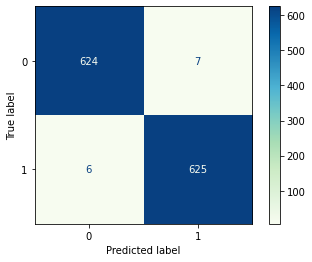

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_cnn, cmap = "GnBu")

In [ ]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_cnn)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_cnn)
print(precision)

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_cnn)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_cnn, pos_label = 0)
print(specificity)

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print(f1_score)

# no false positives means precision and specificity will be 100%

0.9896988906497622
0.9889240506329114
0.9904912836767037
0.9889064976228209
0.9897070467141726


In [ ]:
# save model
cnn_model.save('../Snakes-or-No-Snakes/cnn_balanced_seed1_5e')

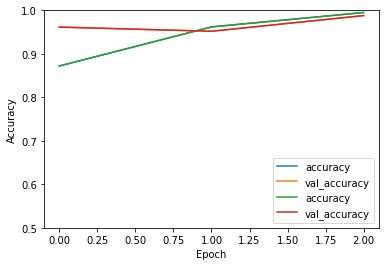

In [ ]:
# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = cnn_model.evaluate(x_test,  y_test, verbose=2)

## Logistic Regression

In [ ]:
def build_log():

  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=(384, 512, 1)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation = "sigmoid"))

  # compile model with desired features
  model.compile(
    optimizer = "adam", loss = "binary_crossentropy",
    metrics=['accuracy']
  )

  return model

In [ ]:
# build the model
log_model = build_log()

In [ ]:
# see model structure
log_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 196609    
                                                                 
Total params: 196,609
Trainable params: 196,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
log_fit = log_model.fit(
    train_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    epochs = 3,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
)

Epoch 1/3
210/210 [==============================] - 4514s 21s/step - loss: 12.8495 - accuracy: 0.8721 - val_loss: 0.0882 - val_accuracy: 0.9615
Epoch 2/3
210/210 [==============================] - 1642s 8s/step - loss: 0.1305 - accuracy: 0.9619 - val_loss: 0.1417 - val_accuracy: 0.9519
Epoch 3/3
210/210 [==============================] - 1645s 8s/step - loss: 0.0228 - accuracy: 0.9951 - val_loss: 0.0372 - val_accuracy: 0.9880


In [ ]:
log_predict = log_model.predict(
    test_generator,
)

In [ ]:
# get class predictions
predictions_log = log_predict > 0.5
predictions_log = predictions_log.reshape(x_test.shape[0])
print(predictions_log.shape)

In [ ]:
set(list(predictions_log.reshape(1262)))

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_log, cmap = "GnBu")

In [ ]:
### model evaluation metrics 

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_log)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_log)
print(precision)

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_log)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_log, pos_label = 0)
print(specificity)

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print(f1_score)

# no false positives means precision and specificity will be 100%

In [ ]:
# save model
log_model.save('../Snakes-or-No-Snakes/log_balanced_seed1_3e')

In [ ]:
# plot accuracy across epochs
plt.plot(log_fit.history['accuracy'], label='accuracy')
plt.plot(log_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# plot accuracy across epochs
plt.plot(log_fit.history['accuracy'], label='accuracy')
plt.plot(log_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = cnn_model.evaluate(x_test,  y_test, verbose=2)

# Sklearn logistic regression

In [ ]:
# take colmean of each image to reduce features (for logistic regression)
image_reshape = image_arr.mean(axis=2)
print(image_reshape.shape)

(23275, 512)


In [ ]:
# scale data 
scaler = sklearn.preprocessing.MinMaxScaler()
image_scaled = scaler.fit_transform(image_reshape)

In [ ]:
# split data
x_train, x_test, y_train, y_test = train_test_split(
    image_reshape, label_arr, test_size = 0.4, stratify = label_arr, shuffle = True, random_state = 27)

x_val, x_test, y_val, y_test = train_test_split(
    x_test, y_test, test_size = 0.75, stratify = y_test, shuffle = True, random_state = 27)

In [ ]:
## initialize logistic regression model
# sag: stochastic average gradient descent, chosen for speed
log_model = sklearn.linear_model.LogisticRegression(solver = "sag", max_iter = 10000)
# fit model on train data
log_model.fit(x_train, y_train)

ValueError: ignored

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_estimator(log_model, x_test, y_test,  cmap = "GnBu")

In [ ]:
### model evaluation metrics 
predictions = log_model.predict(x_test)

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
print(accuracy)

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions)
print(precision)

# true positive/(true positive + false negative) aka recall
sensitivity = sklearn.metrics.recall_score(y_test, predictions)
print(sensitivity)

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions, pos_label = 0)
print(specificity)

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print(f1_score)

# no false positives means precision and specificity will be 100%